# Data Extraction via API

In [4]:
from cryptocompare.blockchain_data import get_blockchain_data
from cryptocompare.ohlcv import get_ohlcv
import pandas as pd

fsyms = ['ETH', 'BTC', 'DOGE', 'MATIC']

# Collect data
ohlcv_data = pd.DataFrame()
blockchain_data = pd.DataFrame()

for fsym in fsyms:
    ohlcv_data_temp = get_ohlcv(fsym)
    ohlcv_data_temp['symbol'] = fsym
    ohlcv_data = pd.concat([ohlcv_data, ohlcv_data_temp])

    blockchain_data_temp = get_blockchain_data(fsym)
    blockchain_data = pd.concat([blockchain_data, blockchain_data_temp])

ohlcv_data = ohlcv_data.reset_index().drop(columns=['index'])

# Save into csv
blockchain_data.to_csv('data/blockchain_data.csv')
ohlcv_data.to_csv('data/ohlcv_data.csv')


---- Extracting price data for ETH ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-12 00:00:00 To 2022-08-05 01:00:00
Run number: 2 

Response received
Date range: From 2011-08-23 01:00:00 To 2017-02-12 00:00:00
No more data received. Terminating the loop at run 2 

---- Extracting blockchain data for ETH ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-12 00:00:00 To 2022-08-05 01:00:00
Run number: 2 

Response received
Date range: From 2011-08-23 01:00:00 To 2017-02-12 00:00:00
Run number: 3 

No more data received. Terminating the loop at run 3 

---- Extracting price data for BTC ... ---- 

Run number: 1 

Response received
Date range: From 2017-02-12 00:00:00 To 2022-08-05 01:00:00
Run number: 2 

Response received
Date range: From 2011-08-23 01:00:00 To 2017-02-12 00:00:00
Run number: 3 

Response received
Date range: From 2006-03-02 00:00:00 To 2011-08-23 01:00:00
No more data received. Terminating the loop at run 3 

---- Extracting bl

# Feature Engineering and Feature Selection

## Load data from CSV file

In [1]:
import pandas as pd

blockchain_data = pd.read_csv('data/blockchain_data.csv')
blockchain_data = blockchain_data.drop(columns=['Unnamed: 0', 'index', 'id'])
blockchain_data = blockchain_data.drop_duplicates(subset=['date', 'symbol'], keep='first')

ohlcv_data = pd.read_csv('data/ohlcv_data.csv')
ohlcv_data = ohlcv_data.drop(columns=['Unnamed: 0', 'level_0', 'time'])
ohlcv_data = ohlcv_data.drop_duplicates(subset=['date', 'symbol'], keep='first')

google_trends_eth = pd.read_csv('data/Google_Trends_historical_interest.csv')


# # Merge ohlcv and blockhain data
# df = pd.merge(ohlcv_data, blockchain_data, how='inner', on=['date', 'symbol'])


## Build Technical indicators and Target variables

In [2]:
fsyms = ['ETH', 'BTC', 'DOGE', 'MATIC']

from data_engineering import build_features_TA, build_target

features = build_features_TA(ohlcv_data, fsyms)
outcomes = build_target(ohlcv_data, fsyms)

## Data pre-processing

In [3]:
import datetime

features_eth = features[features['symbol'] == 'ETH']
features_eth = features_eth.drop(columns=['symbol'])
features_eth['date'] = (features_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
                        )

outcomes_eth = outcomes[outcomes['symbol'] == 'ETH']
outcomes_eth['date'] = outcomes_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )


features_eth_blockchain = blockchain_data[blockchain_data['symbol'] == 'ETH']

features_eth_blockchain = features_eth_blockchain.drop(columns=['symbol', 'time'])
features_eth_blockchain['date'] = features_eth_blockchain.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
ohlcv_eth = ohlcv_data[ohlcv_data['symbol'] == 'ETH']

ohlcv_eth['date'] = (ohlcv_eth.date.apply(
                        lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
                            .replace(
                                hour=0, 
                                minute=0, 
                                second=0, 
                                microsecond=0)
                                )
                        )

google_trends_eth['date'] = google_trends_eth['date'].apply( lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') )

google_trends_eth = google_trends_eth.set_index('date').resample('D').sum()
google_trends_eth = google_trends_eth.reset_index().drop(columns='isPartial')

features_eth = features_eth.set_index('date')
features_eth_blockchain = features_eth_blockchain.set_index('date')
google_trends_eth = google_trends_eth.set_index('date')
outcomes_eth = outcomes_eth.set_index('date')
ohlcv_eth = ohlcv_eth.set_index('date')

# nonnull_dates = outcomes_eth.merge(features_eth, how='inner', on='date').dropna().date
nonnull_index = outcomes_eth.merge(features_eth, how='inner', on='date').dropna().index

features_eth = features_eth.loc[nonnull_index, :]
features_eth_blockchain = features_eth_blockchain.loc[nonnull_index, :]
google_trends_eth = google_trends_eth.loc[nonnull_index, :]
outcomes_eth = outcomes_eth.loc[nonnull_index, :]
ohlcv_eth = ohlcv_eth.loc[nonnull_index, :]

# Reset indices
features_eth = features_eth.reset_index()
features_eth_blockchain = features_eth_blockchain.reset_index()
google_trends_eth = google_trends_eth.reset_index()
outcomes_eth = outcomes_eth.reset_index()
ohlcv_eth = ohlcv_eth.reset_index()


print(features_eth.shape, features_eth_blockchain.shape, outcomes_eth.shape, google_trends_eth.shape, ohlcv_eth.shape)


C:\Users\yesbo\AppData\Local\Temp\ipykernel_19396\2272505031.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcomes_eth['date'] = outcomes_eth.date.apply(
C:\Users\yesbo\AppData\Local\Temp\ipykernel_19396\2272505031.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlcv_eth['date'] = (ohlcv_eth.date.apply(


(2489, 33) (2489, 15) (2489, 16) (2489, 3) (2489, 10)


## Plotting Technical Indicators

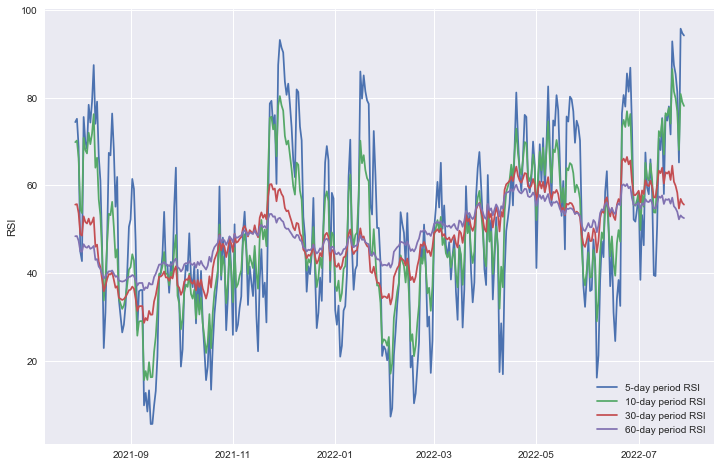

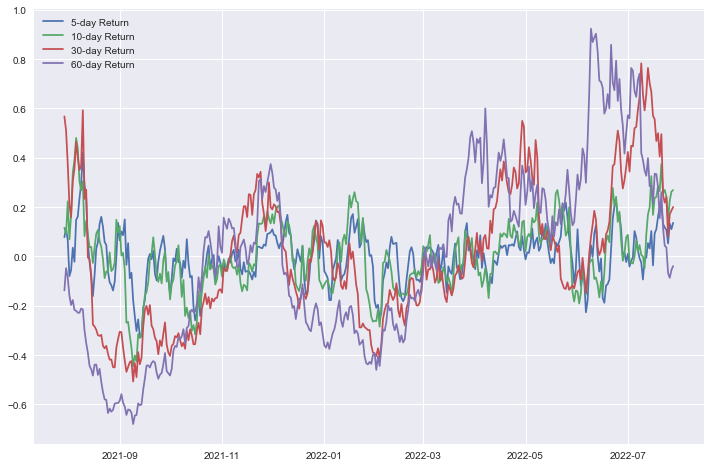

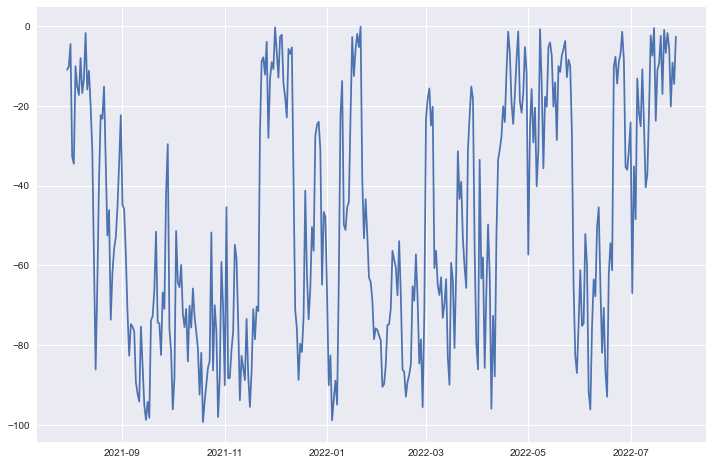

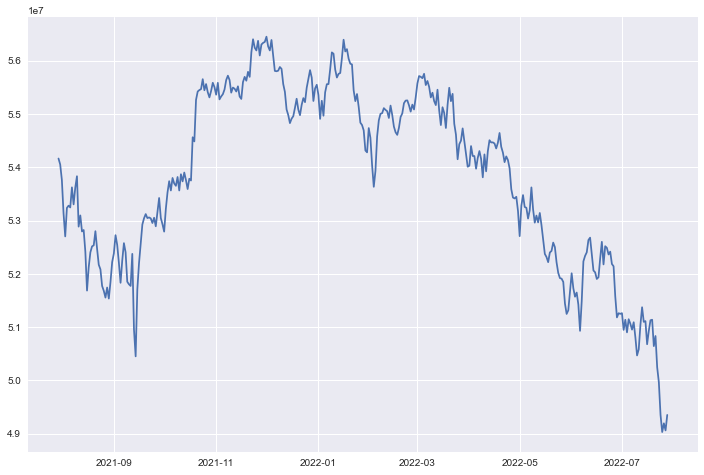

In [21]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.figure(figsize=(12, 8))
for i in [5, 10, 30, 60]:
    plt.plot(features_eth['date'][-365:-1], features_eth[f'rsi_{i}'][:-365:-1], label=f'{i}-day period RSI')
plt.legend()
plt.ylabel('RSI')
plt.show()

plt.figure(figsize=(12, 8))
for i in [5, 10, 30, 60]:
    plt.plot(features_eth['date'][-365:-1], features_eth[f'return_{i}'][:-365:-1], label=f'{i}-day Return')
plt.legend()

plt.figure(figsize=(12, 8))
plt.plot(features_eth['date'][-365:-1], features_eth['WILLR'][:-365:-1], label='Williams %R')

plt.figure(figsize=(12, 8))
plt.plot(features_eth['date'][-365:-1], features_eth['ADI'][:-365:-1], label='ADI')

# plt.legend()
# features_eth

In [6]:
features_eth.columns

Index(['date', 'return_5', 'close_sma_5', 'close_ema_5', 'close-sma_5',
       'close-ema_5', 'return_10', 'close_sma_10', 'close_ema_10',
       'close-sma_10', 'close-ema_10', 'return_30', 'close_sma_30',
       'close_ema_30', 'close-sma_30', 'close-ema_30', 'return_60',
       'close_sma_60', 'close_ema_60', 'close-sma_60', 'close-ema_60', 'rsi_5',
       'rsi_10', 'rsi_30', 'rsi_60', 'macd_diff', 'ADI', 'WILLR', 'ULTOSC',
       'OBV_pct_change_1', 'OBV_diff_1', 'ADI_pct_change_1', 'ADI_diff_1'],
      dtype='object')

# Exploratory Data Analysis

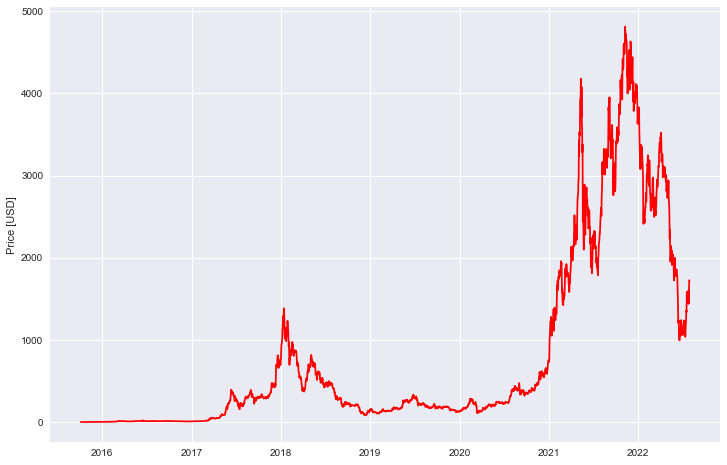

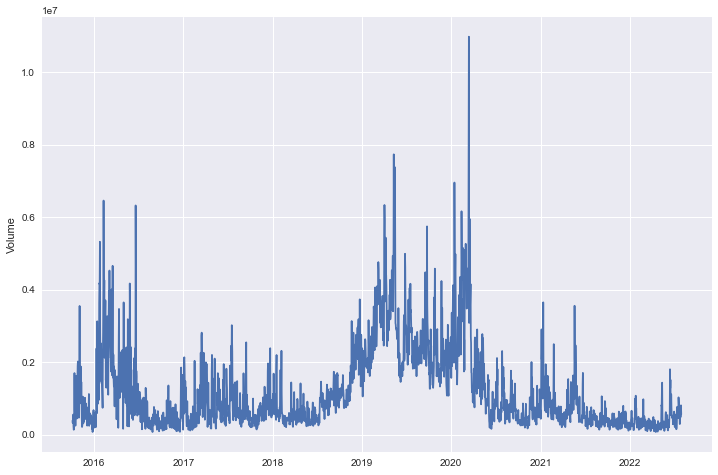

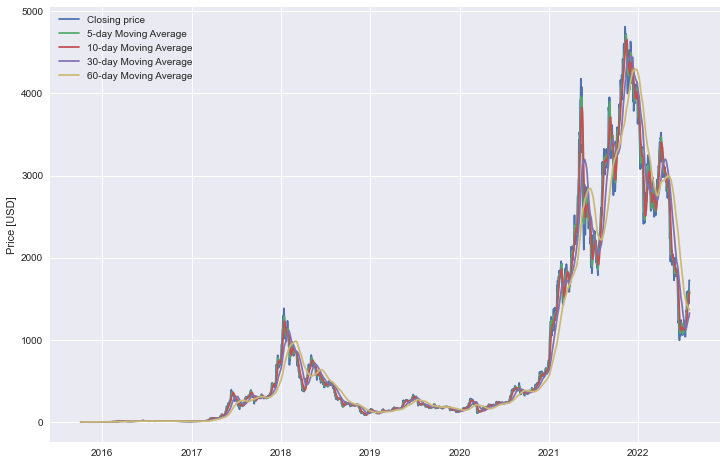

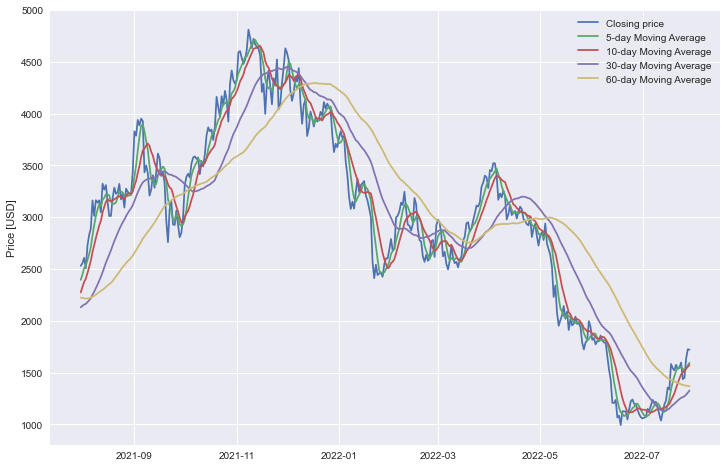

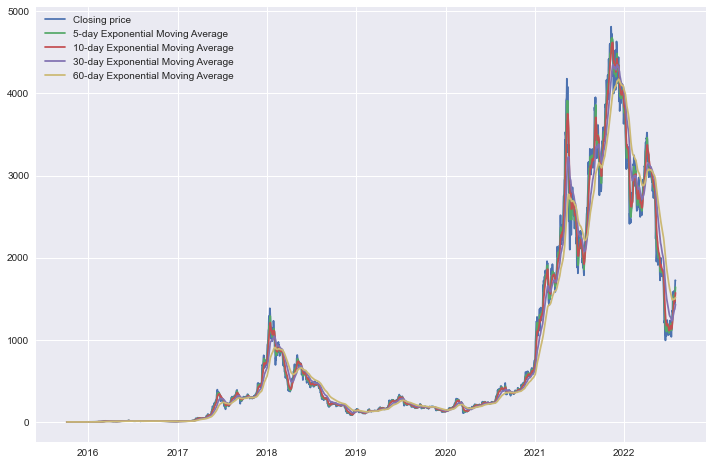

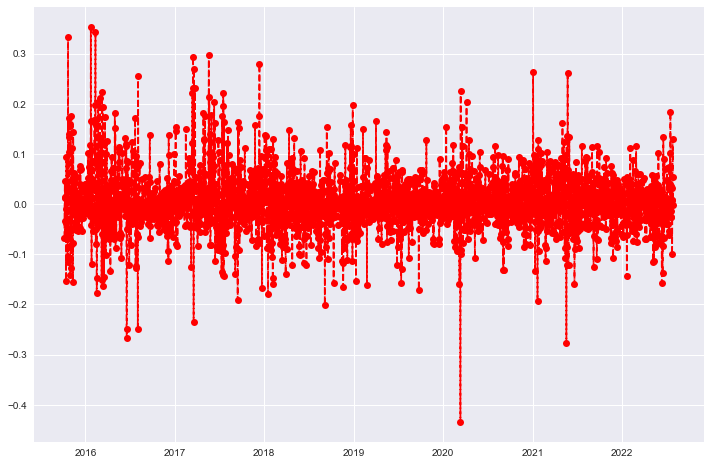

d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


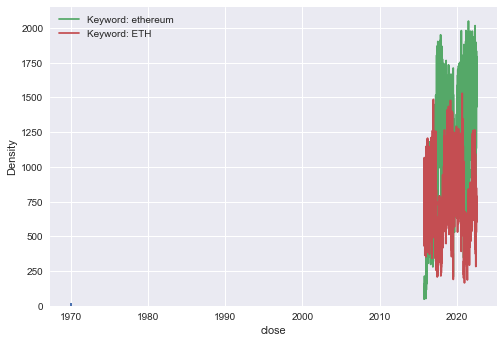

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth['date'], ohlcv_eth['close'], color='red')
plt.ylabel('Price [USD]')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth['date'], ohlcv_eth['volumefrom'])
plt.ylabel('Volume')

plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth['date'], ohlcv_eth['close'], label = 'Closing price')
plt.plot(ohlcv_eth['date'], features_eth['sma_5'], label='5-day Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['sma_10'], label='10-day Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['sma_30'], label='30-day Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['sma_60'], label='60-day Moving Average')
plt.ylabel('Price [USD]')
plt.legend()

plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth[:-365:-1]['date'], ohlcv_eth[:-365:-1]['close'], label = 'Closing price')
plt.plot(ohlcv_eth[:-365:-1]['date'], features_eth[:-365:-1]['sma_5'], label='5-day Moving Average')
plt.plot(ohlcv_eth[:-365:-1]['date'], features_eth[:-365:-1]['sma_10'], label='10-day Moving Average')
plt.plot(ohlcv_eth[:-365:-1]['date'], features_eth[:-365:-1]['sma_30'], label='30-day Moving Average')
plt.plot(ohlcv_eth[:-365:-1]['date'], features_eth[:-365:-1]['sma_60'], label='60-day Moving Average')
plt.ylabel('Price [USD]')
plt.legend()



plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth['date'], ohlcv_eth['close'], label = 'Closing price')
plt.plot(ohlcv_eth['date'], features_eth['ema_5'], label='5-day Exponential Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['ema_10'], label='10-day Exponential Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['ema_30'], label='30-day Exponential Moving Average')
plt.plot(ohlcv_eth['date'], features_eth['ema_60'], label='60-day Exponential Moving Average')
plt.legend()


plt.figure(figsize=(12, 8))
plt.plot(ohlcv_eth['date'], ohlcv_eth['close'].pct_change(), label = 'Daily return', color = 'red', linestyle='--', marker='o')
plt.show()
plt.xlabel('Daily return')

sns.distplot(ohlcv_eth['close'].pct_change())



## Blockchain data

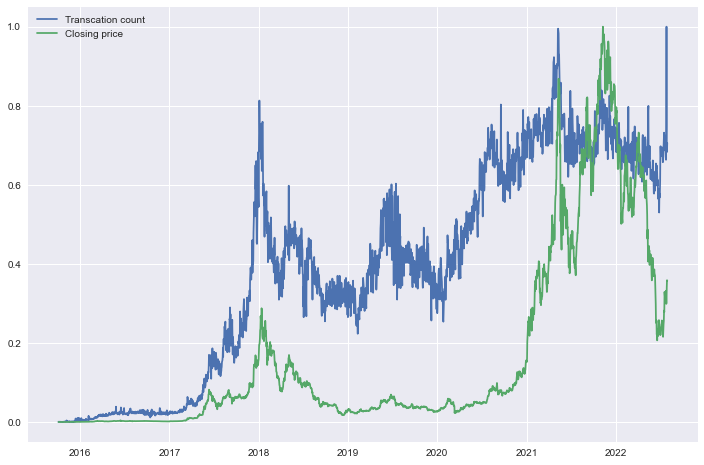

In [65]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

import scipy 

scaler = MinMaxScaler()

plt.figure(figsize=(12, 8))

plt.plot(features_eth_blockchain['date'], scaler.fit_transform(features_eth_blockchain['transaction_count'].values.reshape(-1, 1)) , label='Transcation count')
plt.plot(features_eth_blockchain['date'], scaler.fit_transform(ohlcv_eth['close'].values.reshape(-1, 1)), label='Closing price')
plt.legend()

# plt.plot(features_eth_blockchain['date'], features_eth_blockchain['active_addresses'], label=' transaction count')



In [43]:
features_eth_blockchain


,date,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
0,2015-10-06,3755,23953,95,1554,6456,296291,0,78.481683,344703.0,0.349125,6.276470e+12,17.977732,781.0,7.382568e+07
1,2015-10-07,3767,24048,95,1511,7113,303404,0,43.614287,349707.0,0.346501,5.983538e+12,17.268439,808.0,7.385181e+07
2,2015-10-08,3787,24114,66,1459,6926,310330,0,45.260881,354859.0,0.356495,5.977784e+12,16.768200,788.0,7.387859e+07
3,2015-10-09,3803,24188,74,1489,6761,317091,0,33.183753,359764.0,0.347613,6.122632e+12,17.613377,779.0,7.390404e+07
4,2015-10-10,3820,24248,60,1407,6529,323620,0,19.715809,364660.0,0.341791,6.031582e+12,17.646987,777.0,7.392954e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,2022-07-25,144897712,224054199,76791,642692,1234425,1601894837,3449,2.164470,15214807.0,872.199982,1.178479e+16,13.511573,86433.0,1.216982e+08
2485,2022-07-26,144917617,224137991,83792,1098039,1640575,1603535412,3519,1.610106,15221187.0,873.683394,1.183260e+16,13.543345,84632.0,1.217116e+08
2486,2022-07-27,144952003,224239225,101234,569458,1161419,1604696831,4023,2.822379,15227620.0,879.212611,1.180882e+16,13.431126,81309.0,1.217251e+08
2487,2022-07-28,144988848,224317261,78036,537496,1122646,1605819477,5547,3.238220,15234058.0,894.239719,1.199993e+16,13.419139,84234.0,1.217387e+08


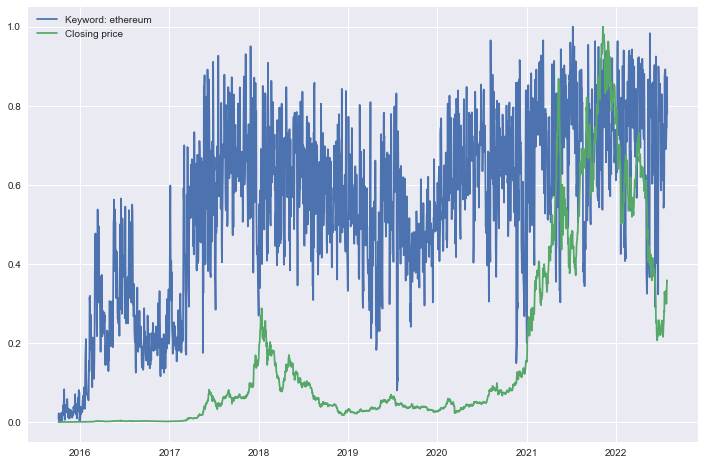

(-0.1, 0.1)

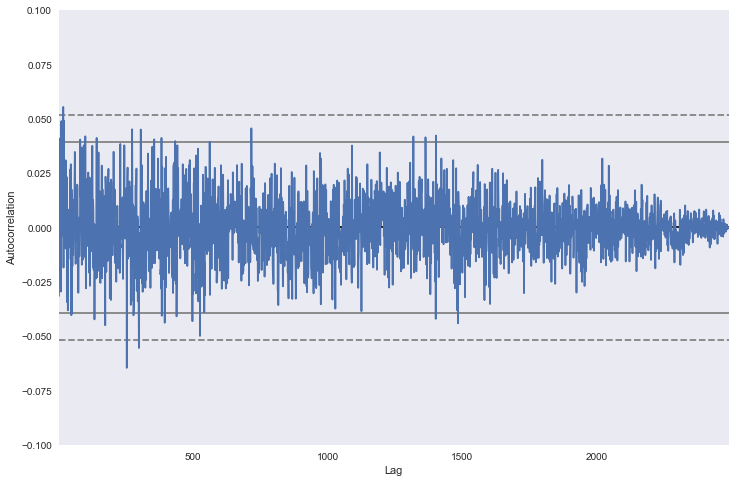

In [40]:
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

import scipy 

scaler = MinMaxScaler()

plt.style.use('seaborn')
plt.figure(figsize=(12, 8))

plt.plot(google_trends_eth['date'], scaler.fit_transform(google_trends_eth['ethereum'].values.reshape(-1, 1)) , label='Keyword: ethereum')
# plt.plot(google_trends_eth['date'], scaler.fit_transform(google_trends_eth['ETH'].values.reshape(-1, 1)), label='Keyword: ETH')
plt.plot(ohlcv_eth['date'], scaler.fit_transform(ohlcv_eth['close'].values.reshape(-1, 1)), label='Closing price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
autocorrelation_plot(outcomes_eth['close_1'])
plt.ylim(-0.1, 0.1)

# # T-test
# scipy.stats.ttest_ind(google_trends_eth['ethereum'], outcomes_eth['close_1'])

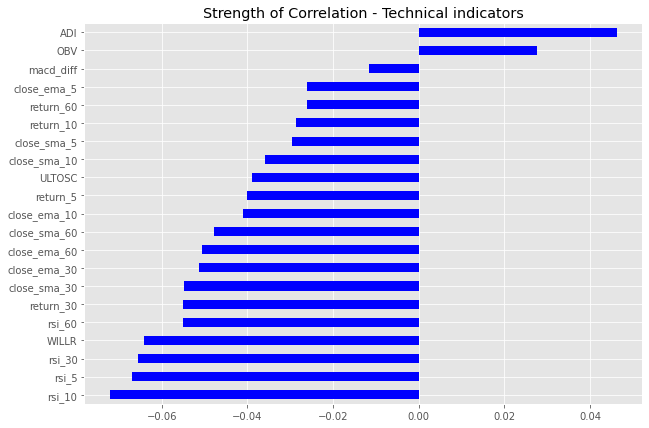

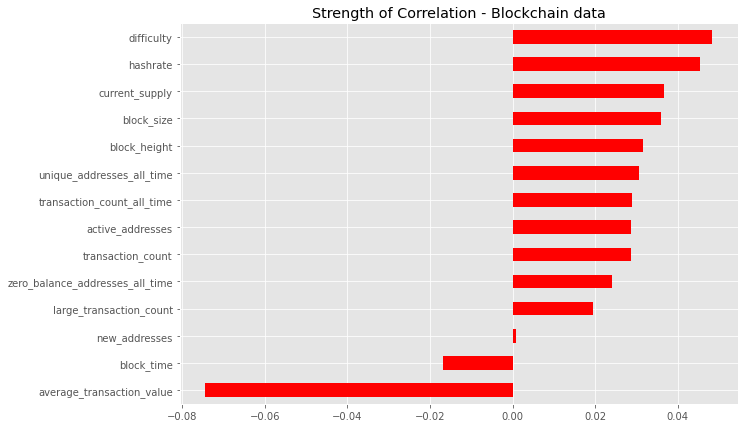

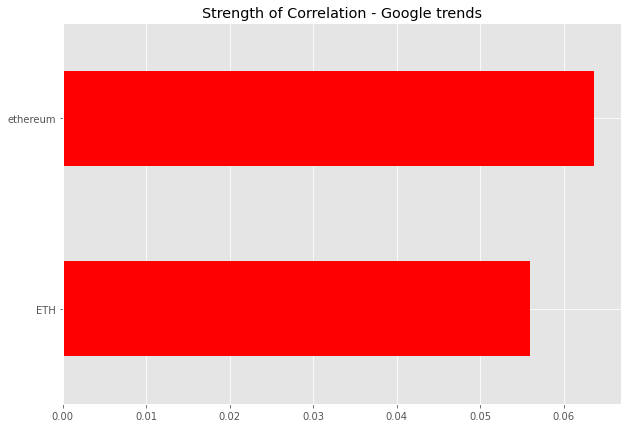

In [26]:
import matplotlib.pyplot as plt

# Correlation strength
plt.style.use('ggplot')

plt.figure(figsize=(10,7))

corr = features_eth.corrwith(outcomes_eth['close_1'])
corr.sort_values().plot.barh(color = 'blue', title = 'Strength of Correlation - Technical indicators')
plt.show()

plt.figure(figsize=(10,7))
plt.style.use('ggplot')
corr = features_eth_blockchain.corrwith(outcomes_eth['close_1'])
corr.sort_values().plot.barh(color = 'red', title = 'Strength of Correlation - Blockchain data')
plt.show()

plt.figure(figsize=(10,7))

plt.style.use('ggplot')
corr = google_trends_eth.corrwith(outcomes_eth['close_1'])
corr.sort_values().plot.barh(color = 'red', title = 'Strength of Correlation - Google trends')
plt.show()

Index(['date', 'return_5', 'close_sma_5', 'close_ema_5', 'return_10',
       'close_sma_10', 'close_ema_10', 'return_30', 'close_sma_30',
       'close_ema_30', 'return_60', 'close_sma_60', 'close_ema_60', 'rsi_5',
       'rsi_10', 'rsi_30', 'rsi_60', 'macd_diff', 'OBV', 'ADI', 'WILLR',
       'ULTOSC'],
      dtype='object')

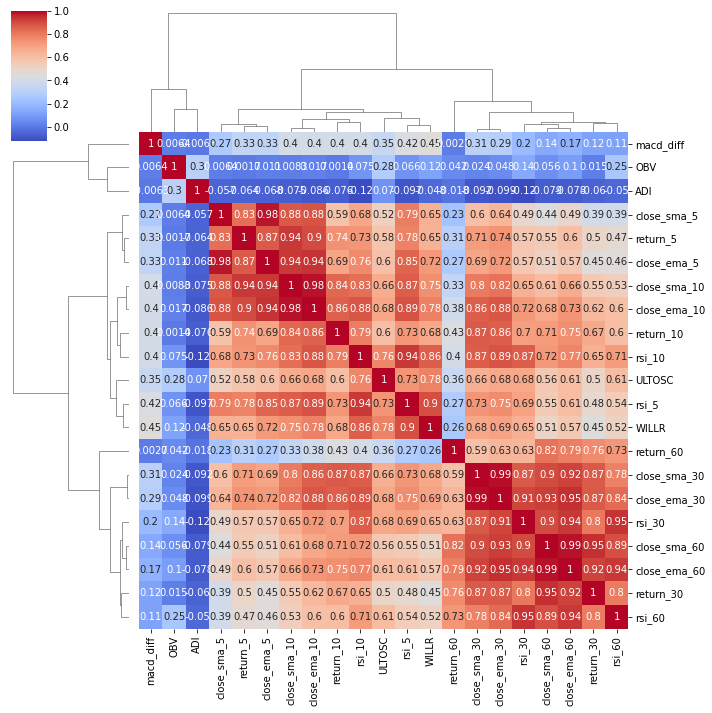

In [23]:
import seaborn as sns
from collinearity import SelectNonCollinear

#  Multicoliniarity

sns.clustermap(features_eth.drop(columns='date').corr(), cmap='coolwarm', annot=True, method='ward')




# **Prediction models**

## *Construct datasets*

In [4]:
dataset_1 = features_eth
dataset_2 = features_eth_blockchain
dataset_3 = google_trends_eth
dataset_4 = features_eth.merge(features_eth_blockchain)
dataset_5 = dataset_4.merge(google_trends_eth)

## Baseline model (Momentum)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

ohlcv_eth['direction_past_1'] = ohlcv_eth['close'].pct_change(1).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else None))
momentum_preds = ohlcv_eth.shift(1)[['date', 'direction_past_1']].set_index('date')
momentum_preds = momentum_preds.dropna()
y_true = outcomes_eth.set_index('date').loc[momentum_preds.index]['direction_1']

# accuracy_score(y_true, momentum_preds['direction_past_1'])

print('Accuracy:', round(accuracy_score(y_true, momentum_preds), 3))
print('F1 score:', round(f1_score(y_true, momentum_preds), 3))
print('Recall:', round(recall_score(y_true, momentum_preds), 3))
print('Precision:', round(precision_score(y_true, momentum_preds), 3))

# movements

### *Run Predictions*


**List of models:**
- *Logistic Regression*
- *Support Vector Machines*
- *XGBoost Classifier*
- *Linear Discriminant Analysis*
- *Quadratic Discriminant Analysis*

## Technical Indicators

In [7]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from run_predictions import fit_predict, evaluate_model, get_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

train_periods = [30, 60, 100, 200]
test_periods = [1, 3, 7, 14]

models = {
            'Logistic Regression': LogisticRegression(), 
            'Support Vector Machines' :SVC(), 
            'XGBoost Classifier': XGBClassifier(), 
            'Linear Discriminant Analysis': LinearDiscriminantAnalysis(), 
            'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis()
        }

predictions = {}

for train_period in train_periods:
    for test_period in test_periods:
        for model in models:
            print('Training models on >')
            print('Train period: {train_period}\t Test period: {test_period}\n'.format(train_period=train_period, test_period=test_period))
            index = '{train_period}_{test_period}_{model}'.format(train_period=train_period, test_period=test_period, model=model)

            print('Running predictions for {model}'.format(model=model))

            predictions[index] = fit_predict(
                models[model], dataset_1, outcomes_eth['direction_1'], train_period=train_period, test_period=test_period)

# for model in models:
#     print('Running predictions for {model}'.format(model=model))
#     predictions[model] = fit_predict(models[model], dataset_1, outcomes_eth['direction_1'], train_period=200, test_period=7)


Training models on >
Train period: 14	 Test period: 1

Running predictions for Logistic Regression
Training models on >
Train period: 14	 Test period: 1

Running predictions for Support Vector Machines
Training models on >
Train period: 14	 Test period: 1

Running predictions for XGBoost Classifier
Training models on >
Train period: 14	 Test period: 1

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 14	 Test period: 1

Running predictions for Random Forest
Training models on >
Train period: 14	 Test period: 1

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 14	 Test period: 3

Running predictions for Logistic Regression
Training models on >
Train period: 14	 Test period: 3

Running predictions for Support Vector Machines
Training models on >
Train period: 14	 Test period: 3

Running predictions for XGBoost Classifier
Training models on >
Train period: 14	 Test period: 3

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 14	 Test period: 3

Running predictions for Random Forest
Training models on >
Train period: 14	 Test period: 3

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 14	 Test period: 7

Running predictions for Logistic Regression
Training models on >
Train period: 14	 Test period: 7

Running predictions for Support Vector Machines
Training models on >
Train period: 14	 Test period: 7

Running predictions for XGBoost Classifier
Training models on >
Train period: 14	 Test period: 7

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 14	 Test period: 7

Running predictions for Random Forest
Training models on >
Train period: 14	 Test period: 7

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 14	 Test period: 14

Running predictions for Logistic Regression
Training models on >
Train period: 14	 Test period: 14

Running predictions for Support Vector Machines
Training models on >
Train period: 14	 Test period: 14

Running predictions for XGBoost Classifier
Training models on >
Train period: 14	 Test period: 14

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 14	 Test period: 14

Running predictions for Random Forest
Training models on >
Train period: 14	 Test period: 14

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 30	 Test period: 1

Running predictions for Logistic Regression
Training models on >
Train period: 30	 Test period: 1

Running predictions for Support Vector Machines
Training models on >
Train period: 30	 Test period: 1

Running predictions for XGBoost Classifier
Training models on >
Train period: 30	 Test period: 1

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 30	 Test period: 1

Running predictions for Random Forest
Training models on >
Train period: 30	 Test period: 1

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 30	 Test period: 3

Running predictions for Logistic Regression
Training models on >
Train period: 30	 Test period: 3

Running predictions for Support Vector Machines
Training models on >
Train period: 30	 Test period: 3

Running predictions for XGBoost Classifier
Training models on >
Train period: 30	 Test period: 3

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 30	 Test period: 3

Running predictions for Random Forest
Training models on >
Train period: 30	 Test period: 3

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 30	 Test period: 7

Running predictions for Logistic Regression
Training models on >
Train period: 30	 Test period: 7

Running predictions for Support Vector Machines
Training models on >
Train period: 30	 Test period: 7

Running predictions for XGBoost Classifier
Training models on >
Train period: 30	 Test period: 7

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 30	 Test period: 7

Running predictions for Random Forest
Training models on >
Train period: 30	 Test period: 7

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 30	 Test period: 14

Running predictions for Logistic Regression
Training models on >
Train period: 30	 Test period: 14

Running predictions for Support Vector Machines
Training models on >
Train period: 30	 Test period: 14

Running predictions for XGBoost Classifier
Training models on >
Train period: 30	 Test period: 14

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 30	 Test period: 14

Running predictions for Random Forest
Training models on >
Train period: 30	 Test period: 14

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 60	 Test period: 1

Running predictions for Logistic Regression
Training models on >
Train period: 60	 Test period: 1

Running predictions for Support Vector Machines
Training models on >
Train period: 60	 Test period: 1

Running predictions for XGBoost Classifier
Training models on >
Train period: 60	 Test period: 1

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 60	 Test period: 1

Running predictions for Random Forest
Training models on >
Train period: 60	 Test period: 1

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 60	 Test period: 3

Running predictions for Logistic Regression
Training models on >
Train period: 60	 Test period: 3

Running predictions for Support Vector Machines
Training models on >
Train period: 60	 Test period: 3

Running predictions for XGBoost Classifier
Training models on >
Train period: 60	 Test period: 3

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 60	 Test period: 3

Running predictions for Random Forest
Training models on >
Train period: 60	 Test period: 3

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 60	 Test period: 7

Running predictions for Logistic Regression
Training models on >
Train period: 60	 Test period: 7

Running predictions for Support Vector Machines
Training models on >
Train period: 60	 Test period: 7

Running predictions for XGBoost Classifier
Training models on >
Train period: 60	 Test period: 7

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 60	 Test period: 7

Running predictions for Random Forest
Training models on >
Train period: 60	 Test period: 7

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 60	 Test period: 14

Running predictions for Logistic Regression
Training models on >
Train period: 60	 Test period: 14

Running predictions for Support Vector Machines
Training models on >
Train period: 60	 Test period: 14

Running predictions for XGBoost Classifier
Training models on >
Train period: 60	 Test period: 14

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 60	 Test period: 14

Running predictions for Random Forest
Training models on >
Train period: 60	 Test period: 14

Running predictions for Quadratic Discriminant Analysis


d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
d:\UNI\Dissertation\simulations\myvenv\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are col

Training models on >
Train period: 100	 Test period: 1

Running predictions for Logistic Regression
Training models on >
Train period: 100	 Test period: 1

Running predictions for Support Vector Machines
Training models on >
Train period: 100	 Test period: 1

Running predictions for XGBoost Classifier
Training models on >
Train period: 100	 Test period: 1

Running predictions for Linear Discriminant Analysis
Training models on >
Train period: 100	 Test period: 1

Running predictions for Random Forest
Training models on >
Train period: 100	 Test period: 1

Running predictions for Quadratic Discriminant Analysis
Training models on >
Train period: 100	 Test period: 3

Running predictions for Logistic Regression
Training models on >
Train period: 100	 Test period: 3

Running predictions for Support Vector Machines
Training models on >
Train period: 100	 Test period: 3

Running predictions for XGBoost Classifier
Training models on >
Train period: 100	 Test period: 3

Running predictions for

### **Momentum baseline**

Accuracy: 0.533
F1 score: 0.532
Recall: 0.546
Precision: 0.519


## Evaluate models

In [11]:
import matplotlib.pyplot as plt

metrics = {}
cm = {}

for model in predictions:
    y_true = outcomes_eth.set_index('date')['direction_1'].loc[predictions[model].index]
    print('Evaluating model {model}'.format(model=model))
    metrics[model] = evaluate_model(y_true=y_true, y_pred=list(predictions[model]))
    cm[model] = get_confusion_matrix(y_true=y_true, y_pred=list(predictions[model]))

    
pd.DataFrame(metrics)


# predictions = fit_predict(LinearDiscriminantAnalysis(), dataset_1, outcomes_eth['direction_1'], train_period=200, test_period=1)

# y_true = outcomes_eth.set_index('date')['direction_1'].loc[predictions.index]

# metrics, cm = evaluate_model(y_true=y_true, y_pred=predictions)

Evaluating model 14_1_Logistic Regression
Evaluating model 14_1_Support Vector Machines
Evaluating model 14_1_XGBoost Classifier
Evaluating model 14_1_Linear Discriminant Analysis
Evaluating model 14_1_Random Forest
Evaluating model 14_1_Quadratic Discriminant Analysis
Evaluating model 14_3_Logistic Regression
Evaluating model 14_3_Support Vector Machines
Evaluating model 14_3_XGBoost Classifier
Evaluating model 14_3_Linear Discriminant Analysis
Evaluating model 14_3_Random Forest
Evaluating model 14_3_Quadratic Discriminant Analysis
Evaluating model 14_7_Logistic Regression
Evaluating model 14_7_Support Vector Machines
Evaluating model 14_7_XGBoost Classifier
Evaluating model 14_7_Linear Discriminant Analysis
Evaluating model 14_7_Random Forest
Evaluating model 14_7_Quadratic Discriminant Analysis
Evaluating model 14_14_Logistic Regression
Evaluating model 14_14_Support Vector Machines
Evaluating model 14_14_XGBoost Classifier
Evaluating model 14_14_Linear Discriminant Analysis
Evalua

,14_1_Logistic Regression,14_1_Support Vector Machines,14_1_XGBoost Classifier,14_1_Linear Discriminant Analysis,14_1_Random Forest,14_1_Quadratic Discriminant Analysis,14_3_Logistic Regression,14_3_Support Vector Machines,14_3_XGBoost Classifier,14_3_Linear Discriminant Analysis,...,200_7_XGBoost Classifier,200_7_Linear Discriminant Analysis,200_7_Random Forest,200_7_Quadratic Discriminant Analysis,200_14_Logistic Regression,200_14_Support Vector Machines,200_14_XGBoost Classifier,200_14_Linear Discriminant Analysis,200_14_Random Forest,200_14_Quadratic Discriminant Analysis
accuracy,0.502023,0.495550,0.512136,0.500405,0.501618,0.502427,0.679612,0.598301,0.656958,0.591424,...,0.621823,0.505697,0.610868,0.501315,0.567046,0.554777,0.594654,0.522349,0.584137,0.499124
precision,0.487446,0.480687,0.498344,0.485813,0.487542,0.488294,0.674915,0.591426,0.649493,0.578303,...,0.618009,0.492958,0.623348,0.486653,0.557728,0.550104,0.589990,0.509964,0.586426,0.484070
f1_score,0.477726,0.473173,0.499585,0.477801,0.487947,0.487073,0.666386,0.576546,0.644593,0.584020,...,0.601754,0.498221,0.560396,0.454458,0.548033,0.509179,0.569967,0.508123,0.538200,0.451799
recall,0.468386,0.465890,0.500832,0.470050,0.488353,0.485857,0.658070,0.562396,0.639767,0.589850,...,0.586331,0.503597,0.508993,0.426259,0.538669,0.473921,0.551259,0.506295,0.497302,0.423561


In [ ]:
# Visualise confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Parameter tuning

In [6]:
from parameter_tunining import find_best_params
from TimeBasedCV import TimeBasedCV
from sklearn.svm import SVC 

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.5, 1, 3] 
}

tscv = TimeBasedCV(train_period=14, test_period=3)

split_indices = tscv.split(dataset_1, gap=1)

svm_best_params = find_best_params(
    estimator=SVC(), 
    params=params, 
    split_indices=split_indices, 
    features=dataset_1, 
    outcomes=outcomes_eth['direction_1']
    )

svm_best_params

Fitting 824 folds for each of 10 candidates, totalling 8240 fits


## LSTM

In [ ]:
split_point = int(0.80*len(features_eth))
target = outcomes_eth['direction_1']
# train_dataset = features_eth.join(outcomes_eth['direction_1']).iloc[:split_point,:]

train = features.iloc[:split_point, :]
y_train = target.iloc[:split_point, :]

X_test = features.iloc[:split_point, :]
y_test = target.iloc[:split_point, :]

for i in range(60, X_train.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])


# Archive (Just in case)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense


standard_scaler = StandardScaler()

split_point = int(0.80*len(features_eth))

features = features_eth_blockchain.merge(features_eth, on='date')
target = outcomes_eth['direction_5']
# train_dataset = features_eth.join(outcomes_eth['direction_1']).iloc[:split_point,:]

X_train = features.iloc[:split_point, :]
y_train = target.iloc[:split_point]

X_test = features.iloc[split_point:, :] 
y_test = target.iloc[split_point:]

# Transform training dataset
X_train = standard_scaler.fit_transform(X_train)

# Transform test dataset
X_test = standard_scaler.fit_transform(X_test)

# model = LogisticRegression()
model = svm.SVC(kernel='linear', C=1000)


model.fit(X=X_train, y=y_train)

print('Accuracy in-sample: {}'.format(model.score(X=X_train, y=y_train)))
print('Accuracy out-of-sample: {}'.format(model.score(X=X_test, y=y_test)))
# print('Coefficients: {}'.format(model.coef_))

y_pred = model.predict(X_test)

confusion_matrix(y_true=y_test, y_pred=y_pred)

# plt.style.use('ggplot')
# plt.figure(figsize=(15,7))
# plt.plot(y_test, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
# plt.show()

Accuracy in-sample: 0.6290890790135883
Accuracy out-of-sample: 0.4768611670020121


array([[158, 103],
       [157,  79]], dtype=int64)

### Expanding and Rolling Window techniques

In [ ]:
from run_predictions import fit_expanding_window, predict_expanding_window, fit_rolling_window, predict_rolling_window
from sklearn.linear_model import LinearRegression, LogisticRegression

models_expanding_window = fit_expanding_window(features_eth, outcomes_eth['direction_1'], model_instance=LogisticRegression())
predictions_expanding_window = predict_expanding_window(models_expanding_window, features_eth)

models_rolling_window = fit_rolling_window(features_eth, outcomes_eth['direction_1'], model_instance=LogisticRegression())
predictions_rolling_window = predict_rolling_window(models_rolling_window, features_eth)


Predicting for the period between 2015-10-31 00:00:00 and 2015-11-30 00:00:00

Predicting for the period between 2015-11-30 00:00:00 and 2015-12-31 00:00:00

Predicting for the period between 2015-12-31 00:00:00 and 2016-01-31 00:00:00

Predicting for the period between 2016-01-31 00:00:00 and 2016-02-29 00:00:00

Predicting for the period between 2016-02-29 00:00:00 and 2016-03-31 00:00:00

Predicting for the period between 2016-03-31 00:00:00 and 2016-04-30 00:00:00

Predicting for the period between 2016-04-30 00:00:00 and 2016-05-31 00:00:00

Predicting for the period between 2016-05-31 00:00:00 and 2016-06-30 00:00:00

Predicting for the period between 2016-06-30 00:00:00 and 2016-07-31 00:00:00

Predicting for the period between 2016-07-31 00:00:00 and 2016-08-31 00:00:00

Predicting for the period between 2016-08-31 00:00:00 and 2016-09-30 00:00:00

Predicting for the period between 2016-09-30 00:00:00 and 2016-10-31 00:00:00

Predicting for the period between 2016-10-31 00:00:0